In [1]:
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import shape

In [2]:
# Charge le shapefile
gdf = gpd.read_file("data/RPG_2023/PARCELLES_GRAPHIQUES.gpkg")

In [3]:
gdf  = gdf.to_crs(epsg=4326)

In [4]:

######### ad label 

Label_culture = pd.read_csv("REF_CULTURES_GROUPES.csv", sep=";")
Label_culture["Label"] = pd.to_numeric(Label_culture["Label"], errors="coerce").astype("Int64")
Label_culture["Label"] = Label_culture["Label"].fillna(0).astype(int)


gdf = gdf.merge(Label_culture[["Label","CODE_CULTURE"]], how="left", left_on="CODE_CULTU", right_on="CODE_CULTURE")

gdf = gdf.rename(columns={"Label": "LABEL"})


In [5]:
import ee 
import geemap

/Users/placiermoise/Documents/remote sensing crop classification/.venv/lib/python3.12/site-packages/geemap/conversion.py:23: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [6]:
ee.Authenticate(scopes=['https://www.googleapis.com/auth/earthengine',
                        'https://www.googleapis.com/auth/drive'])
ee.Initialize()

In [7]:
Map = geemap.Map()
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [8]:
#### selectionner un polygone fait à la mano sur Map

polygone_hand_draw = Map.draw_features  

first_polygone = polygone_hand_draw[0] 

geom_hand_poly = first_polygone.geometry()

geom_hand_poly

Map.addLayer(geom_hand_poly, {}, "Polygone dessiné")

In [9]:

#  Convertir ee.Geometry en GeoJSON dict
geom_hand_poly_json = geom_hand_poly.getInfo()

#  Convertir GeoJSON dict en shapely geometry
hand_poly_shapely = shape(geom_hand_poly_json)


# Filtrer le GeoDataFrame pour ne garder que les polygones contenus dans geom_hand_poly
gdf_contained = gdf[gdf.geometry.within(hand_poly_shapely)]

# Convertir en GeoJSON pour l'affichage (sert à convertir un GeoDataFrame en un dictionnaire au format GeoJSON natif)
Parcelle_within_hand_Poly_geojson = gdf_contained.__geo_interface__

# Convertir en GEE FeatureCollection
fc = geemap.geopandas_to_ee(gdf_contained, geodesic=False)
fc_geom = fc.geometry()

Map.addLayer(fc_geom, {}, "parcelles")

In [10]:
############ Import raster from the selected zone (hand poly )


Geometry_data_collect = geom_hand_poly

# Get the area value
area_m2 = geom_hand_poly.area(maxError=1)
print("Area (m²):", area_m2.getInfo())

Area (m²): 30411058.04554169


In [11]:
from datetime import datetime, timedelta


start_date = '2023-01-01'
end_date = '2023-12-31'
bands = ['B2', 'B3', 'B4', 'B8']

# Fonction pour générer la liste des périodes (demi-mois)
def generate_half_month_ranges(start_date, end_date):
    date_list = []
    current = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')

    while current < end:
        mid = current + timedelta(days=15)
        end_of_month = (current.replace(day=28) + timedelta(days=4)).replace(day=1)

        date_list.append((current.strftime('%Y-%m-%d'), min(mid, end).strftime('%Y-%m-%d')))
        date_list.append((min(mid, end).strftime('%Y-%m-%d'), min(end_of_month, end).strftime('%Y-%m-%d')))

        current = end_of_month

    return date_list

def generate_date_ranges(start_date, end_date, interval_days=15):
    """
    Génère des intervalles de dates de `interval_days` jours entre `start_date` et `end_date`.

    Args:
        start_date (str): Date de début au format 'YYYY-MM-DD'.
        end_date (str): Date de fin au format 'YYYY-MM-DD'.
        interval_days (int): Longueur de chaque intervalle en jours.

    Returns:
        List[Tuple[str, str]]: Liste de tuples (date_début, date_fin).
    """
    date_list = []
    current = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')

    while current < end:
        next_date = current + timedelta(days=interval_days)
        date_list.append((
            current.strftime('%Y-%m-%d'),
            min(next_date, end).strftime('%Y-%m-%d')
        ))
        current = next_date

    return date_list

# Générer les périodes
#ranges = generate_half_month_ranges(start_date, end_date)
ranges = generate_date_ranges(start_date, end_date, interval_days=30)

In [12]:
def mask_scl(img):
    scl = img.select('SCL')
    # Masquer tous les pixels qui ne sont PAS dans les classes 4 à 7
    mask = (scl.eq(4)
           .Or(scl.eq(5))
           .Or(scl.eq(6))
           .Or(scl.eq(7)))
    return img.updateMask(mask)

def get_median_image(start, end, Geometry_data_collect):
    # Charger les bandes utiles + SCL
    collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
        .filterBounds(Geometry_data_collect) \
        .filterDate(start, end) \
        .map(lambda img: img.clip(Geometry_data_collect)) \
        .map(mask_scl) \
        .select(bands)

    def compute_median():
        return collection.median() \
            .set('system:time_start', ee.Date(start).millis()) \
            .set('start_date', start) \
            .set('end_date', end) \
            .set('Number_of_aggreted_images', size)

    size = collection.size()
    median = ee.Algorithms.If(size.gt(0), compute_median(), None)
    return median

# Créer une liste d'images médianes
median_images = [get_median_image(start, end, Geometry_data_collect) for start, end in ranges]

# Créer une collection à partir des images
s2 = ee.ImageCollection(median_images)

# Exemple : afficher la taille de la collection
print("Nombre d'images médianes :", s2.size().getInfo())

Nombre d'images médianes : 12


In [13]:
s2_list = s2.toList(s2.size())
n_images = s2.size().getInfo()
total_n_img = 0
for i in range(n_images):
    img = ee.Image(s2_list.get(i))
    props = img.toDictionary().getInfo()
    
    num_agg = props['Number_of_aggreted_images']
    total_n_img += num_agg
    print(f"Image {i} composée de {num_agg} images " )

print(total_n_img)

Image 0 composée de 6 images 
Image 1 composée de 6 images 
Image 2 composée de 6 images 
Image 3 composée de 6 images 
Image 4 composée de 6 images 
Image 5 composée de 6 images 
Image 6 composée de 7 images 
Image 7 composée de 6 images 
Image 8 composée de 6 images 
Image 9 composée de 6 images 
Image 10 composée de 6 images 
Image 11 composée de 6 images 
73


In [14]:

# Définir les paramètres d'affichage (Red: B4, Green: B3, Blue: B2)
vis_params = {
    'bands': ['B4', 'B3', 'B2'],  # RGB
    'min': 0,
    'max': 3000,
    'gamma': 1.3
}

# Ajouter à la carte
Map.centerObject(fc, zoom=10)  # centrer sur ta zone d’intérêt (fc)

img_n = 6

s2_list = s2.toList(s2.size())
image = ee.Image(s2_list.get(img_n))
Map.addLayer(geom_hand_poly, {}, "Polygone dessiné")
Map.addLayer(image, vis_params, f'Sentinel-2 RGB {img_n}')

Map

Map(bottom=765715.0, center=[43.64500738037024, 1.0472463503494793], controls=(WidgetControl(options=['positio…

In [ ]:
########## export des tiff
def export_tiff(image_collection,Geometry_data_collect,export_folder,export_maxPixels ): 
    # superposition des pixels 

    image_list = image_collection.toList(image_collection.size())
    n = image_collection.size().getInfo()
    
    for i in range(n):
        image = ee.Image(image_list.get(i)).clip(Geometry_data_collect)
        
        # Construire un nom unique, par exemple date acquisition
        date_str = image.date().format('YYYYMMdd').getInfo()
        task = ee.batch.Export.image.toDrive(
            image=image,
            description= "export",
            folder=export_folder,
            fileNamePrefix=f'sentinel2_{date_str}',
            region=Geometry_data_collect,
            scale=10,
            crs='EPSG:4326',
            maxPixels=export_maxPixels
        )
        task.start()
        print(f"Export lancé pour l’image {i+1}/{n}, date : {date_str}")

In [16]:
######### export au format tiff
image_collection = s2
export_folder = 'GEE_export_6_median'
export_maxPixels = 1e10


export_tiff(image_collection,Geometry_data_collect,export_folder,export_maxPixels )

Export lancé pour l’image 1/12, date : 20230101
Export lancé pour l’image 2/12, date : 20230131
Export lancé pour l’image 3/12, date : 20230302
Export lancé pour l’image 4/12, date : 20230401
Export lancé pour l’image 5/12, date : 20230501
Export lancé pour l’image 6/12, date : 20230531
Export lancé pour l’image 7/12, date : 20230630
Export lancé pour l’image 8/12, date : 20230730
Export lancé pour l’image 9/12, date : 20230829
Export lancé pour l’image 10/12, date : 20230928
Export lancé pour l’image 11/12, date : 20231028
Export lancé pour l’image 12/12, date : 20231127


In [ ]:
# Pixel Count
s2_first_img = ee.Image(s2.first())  # ou .mosaic() si tu veux éviter les nuages

# Option 1 : utiliser pixelCount
pixel_count = s2_first_img.select('B2').reduceRegion(
    reducer=ee.Reducer.count(),
    geometry=Geometry_data_collect,
    scale=10,
    maxPixels=1e9
)

print("Nombre de pixels valides dans B2 :", pixel_count.getInfo()['B2'])

Nombre de pixels valides dans B2 : 141726


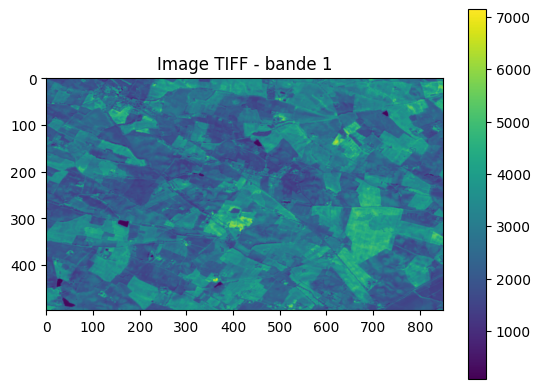

In [21]:
import rasterio
import matplotlib.pyplot as plt

# Ouvrir le fichier TIFF
with rasterio.open('/Users/placiermoise/Library/CloudStorage/GoogleDrive-moise.placier@gmail.com/Mon Drive/GEE_export_6_median/sentinel2_2.tif') as src:
    img = src.read(4) 

plt.imshow(img, cmap='viridis')  # ou 'viridis', 'jet', etc.
plt.colorbar()
plt.title('Image TIFF - bande 1')
plt.show()

#src.close()

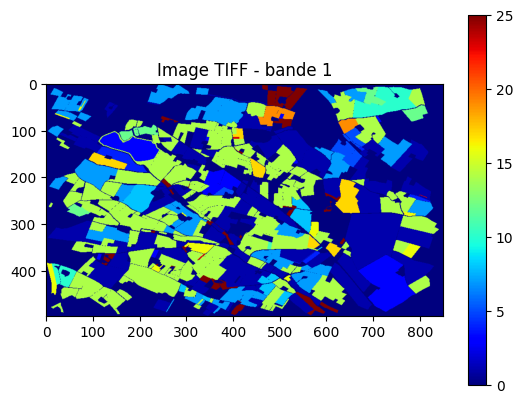

In [22]:
import rasterio
from rasterio.features import rasterize
import geopandas as gpd

# Charger les polygones d’annotations (avec un champ "class_id")
gdf_to_rasterize = gdf_contained

# Charger une image de référence pour récupérer la taille, la transformée et la projection
with rasterio.open('/Users/placiermoise/Library/CloudStorage/GoogleDrive-moise.placier@gmail.com/Mon Drive/GEE_export_6_median/sentinel2_2.tif') as src:
    meta = src.meta.copy()

# Rasterize 
shapes = ((geom, value) for geom, value in zip(gdf_to_rasterize.geometry, gdf_to_rasterize['LABEL']))
label_raster = rasterize(
    shapes,
    out_shape=(meta['height'], meta['width']),
    transform=meta['transform'],
    fill=0,  # background label
    dtype=rasterio.uint8
)

# Sauvegarder le raster labelisé
meta.update({'count': 1, 'dtype': rasterio.uint8})
with rasterio.open('labels_raster.tif', 'w', **meta) as dst:
    dst.write(label_raster, 1)

with rasterio.open('labels_raster.tif') as src:
    img = src.read(1)  # lire la première bande

plt.imshow(img, cmap='jet')  
plt.colorbar()
plt.title('Image TIFF - bande 1')
plt.show()

In [23]:

with rasterio.open('labels_raster.tif') as src:
    img_reference = src.read(1)  # lire la première bande

img_reference

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(497, 850), dtype=uint8)

In [27]:
import os
import argparse
import numpy as np
import h5py
import rasterio
from rasterio.windows import Window
from tqdm import tqdm


tif_dir = '/Users/placiermoise/Library/CloudStorage/GoogleDrive-moise.placier@gmail.com/Mon Drive/GEE_export_6_median/'

def mask_no_label(tif_dir):
    with rasterio.open('labels_raster.tif') as src:
        img_reference = src.read(1)  # lire la première bande
    # Get all tif files sorted by date
    tif_files = sorted([os.path.join(tif_dir, f) for f in os.listdir(tif_dir) if f.endswith('.tif')])

    for tif_path in tqdm(tif_files, desc="mask des TIF"):
        with rasterio.open(tif_path) as src:
            data = src.read()  # Shape: (bands, height, width)
            profile = src.profile
            # Masque: True là où la valeur de référence est 0
            mask = (img_reference == 0)
            # Appliquer le masque à toutes les bandes
            data[:, mask] = 0
        # Sauvegarde dans un nouveau fichier
        base_name = os.path.basename(tif_path).replace('.tif', '_masked.tif')
        output_path = os.path.join('data/Tif', base_name)

        # Écriture du fichier masqué
        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(data)

mask_no_label(tif_dir)

mask des TIF: 100%|██████████| 12/12 [00:02<00:00,  5.44it/s]


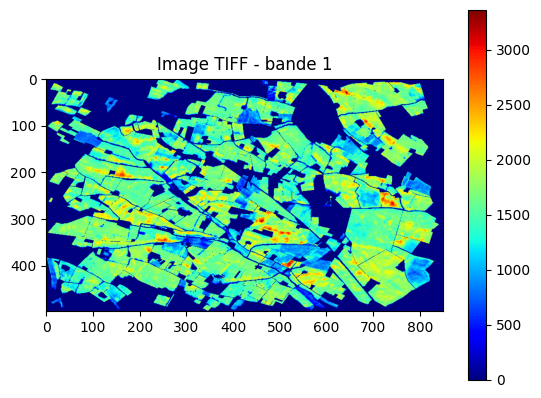

In [32]:
with rasterio.open('data/Tif/sentinel2_9_masked.tif') as src:
    img = src.read(3) 

plt.imshow(img, cmap='jet')  # ou 'viridis', 'jet', etc.
plt.colorbar()
plt.title('Image TIFF - bande 1')
plt.show()

In [ ]:
##################### Making the patches !!! 

In [ ]:
patches = []
from rasterio.windows import Window
width, height = src.width, src.height
patch_size=(24, 24)
stride=24
with rasterio.open('/Users/placiermoise/Library/CloudStorage/GoogleDrive-moise.placier@gmail.com/Mon Drive/GEE_exports_test1/sentinel2_0_20230207.tif') as src:
    width, height = src.width, src.height
    tag = src.tags()
    for i in range(0, width - patch_size[0] + 1, stride):
        for j in range(0, height - patch_size[1] + 1, stride):
            window = Window(i, j, *patch_size)
            patch = src.read(window=window)  # shape: (bands, H, W)
            patches.append(patch)

In [167]:
tag

{'AREA_OR_POINT': 'Area'}

In [165]:
len(patches)

171

In [33]:
import h5py
import os

# Chemin vers ton fichier HDF5
h5_path = 'data/dataset.h5'

# Taille du fichier sur disque (en MB)
file_size_mb = os.path.getsize(h5_path) / (1024 * 1024)
print(f"Taille du fichier : {file_size_mb:.2f} MB")

# Ouvrir et inspecter le contenu
with h5py.File(h5_path, 'r') as f:
    print("\nClés trouvées dans le fichier HDF5 :")
    for key in f.keys():
        data = f[key]
        print(f"- {key} : shape={data.shape}, dtype={data.dtype}")

Taille du fichier : 37.51 MB

Clés trouvées dans le fichier HDF5 :
- data : shape=(700, 36, 4, 24, 24), dtype=float64


In [67]:
s2_firts.getInfo()

{'type': 'Image',
 'bands': [{'id': 'B2',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [2789, 1747],
   'origin': [4897, 5011],
   'crs': 'EPSG:32631',
   'crs_transform': [10, 0, 300000, 0, -10, 5500020]},
  {'id': 'B3',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [2789, 1747],
   'origin': [4897, 5011],
   'crs': 'EPSG:32631',
   'crs_transform': [10, 0, 300000, 0, -10, 5500020]},
  {'id': 'B4',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [2789, 1747],
   'origin': [4897, 5011],
   'crs': 'EPSG:32631',
   'crs_transform': [10, 0, 300000, 0, -10, 5500020]},
  {'id': 'B8',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [2789, 1747],
   'origin': [4897, 5011],
   'crs': 'EPSG:32631',
   'crs_transform': [10, 0, 300000, 0, -